### Otros
### IPN- CIC
### Alumno: Jorge Diego García Torres
#### Titulo : Clasificación de los grados de retinopatía diabética en imágenes del fondo del ojo mediante algoritmos de aprendizaje profundo.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import os, os.path

DIR = '/content/gdrive/My Drive/APTOS1/test_images/'
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))


DIR2 = '/content/gdrive/My Drive/APTOS1/train_images/'
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

3862
3862


In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
#from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tqdm import tqdm

%matplotlib inline

In [ ]:
train_df = pd.read_csv('/content/gdrive/My Drive/train.csv')

In [ ]:

train_df = pd.read_csv('/content/gdrive/My Drive/APTOS1/train.csv')
test_df = pd.read_csv('/content/gdrive/My Drive/APTOS1/test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(3662, 2)
(1928, 1)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): 
            return img 
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
 
            img = np.stack([img1,img2,img3],axis=-1)

        return img

In [ ]:
def circle_crop(img, sigmaX = 30):   
    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

In [ ]:
def circle_crop1(img, sigmaX = 30):   
     
    img = crop_image_from_gray(img)  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

In [ ]:
def circle_crop2(img, sigmaX = 30):   
        
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

In [ ]:
from PIL import Image

def resize(image_pil, width, height):
 
    ratio_w = width / image_pil.width
    ratio_h = height / image_pil.height
    if ratio_w < ratio_h:

        resize_width = width
        resize_height = round(ratio_w * image_pil.height)
    else:

        resize_width = round(ratio_h * image_pil.width)
        resize_height = height
    image_resize = image_pil.resize((resize_width, resize_height), Image.ANTIALIAS)
    background = Image.new('RGBA', (width, height), (0, 0, 0, 0)) #fondo negro o blanco
    offset = (round((width - resize_width) / 2), round((height - resize_height) / 2))
    background.paste(image_resize, offset)
    return background.convert('RGB')

In [ ]:
img = cv2.imread('/content/gdrive/My Drive/APTOS1/train_images/000c1434d8d7.png')

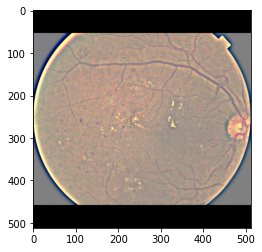

In [ ]:
img = cv2.imread('/content/gdrive/My Drive/APTOS1/train_images/000c1434d8d7.png')
img=circle_crop1(img)
pilim =Image.fromarray(img)
img= resize(pilim,512,512)
imga=np.array(img) 
plt.imshow(imga/255.)

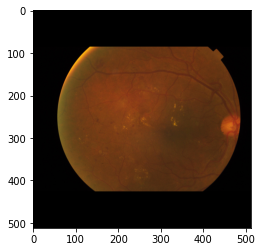

In [ ]:
img = cv2.imread('/content/gdrive/My Drive/APTOS1/train_images/000c1434d8d7.png')
image = crop_image_from_gray(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pilim =Image.fromarray(img)
img= resize(pilim,512,512)
imga=np.array(img) 
plt.imshow(imga/255.)

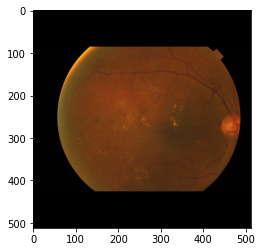

In [ ]:
img = cv2.imread('/content/gdrive/My Drive/APTOS1/train_images/000c1434d8d7.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pilim =Image.fromarray(img)
img= resize(pilim,512,512)
imga=np.array(img) 
plt.imshow(imga)

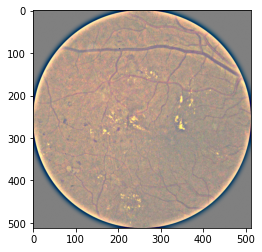

In [ ]:
N = train_df.shape[0]
x_train = np.zeros((N, 512, 512, 3), dtype='uint8')

img = cv2.imread('/content/gdrive/My Drive/APTOS1/train_images/000c1434d8d7.png')
img=circle_crop(img)
pilim =Image.fromarray(img)
img= resize(pilim,512,512)
imga=np.array(img) 
plt.imshow(imga/255.)

In [ ]:
size = 512

N = train_df.shape[0]
x_train = np.zeros((N, size, size, 3), dtype='uint8')

for i, image_id in enumerate(tqdm(train_df['id_code'])):
  img = cv2.imread(f'/content/gdrive/My Drive/APTOS1/train_images/{image_id}.png')
  img=circle_crop1(img)
  pilim =Image.fromarray(img)
  img= resize(pilim,512,512)
  imga=np.array(img) 
  x_train[i] = imga

100%|██████████| 3662/3662 [1:20:34<00:00,  1.32s/it]


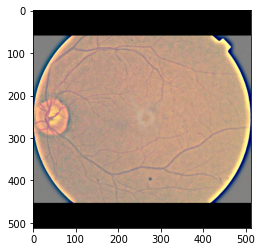

In [ ]:
plt.imshow(x_train[2])

In [ ]:
from numpy import asarray
from numpy import save

data = asarray(x_train)
save('/content/gdrive/My Drive/xtrain2512.npy', data)

In [ ]:
from numpy import load

In [ ]:
x_train = load('/content/gdrive/My Drive/xtrain1224.npy')

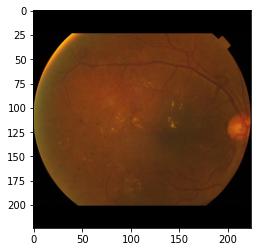

In [ ]:
plt.imshow(x_train[0])

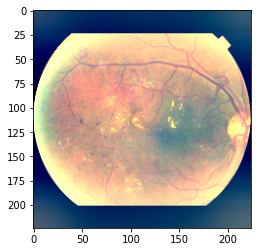

In [ ]:
imgtest = circle_crop2(x_train[0])
plt.imshow(imgtest)

In [ ]:
image = x_train[0]

image = cv2.addWeighted(image,4, cv2.GaussianBlur( image , (0,0) , 30) ,-4 ,128)

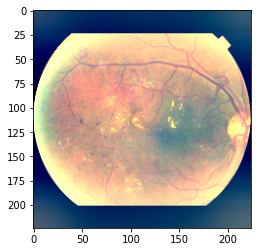

In [ ]:
plt.imshow(image)

In [ ]:
x_train = load('/content/gdrive/My Drive/xtrain2224.npy')

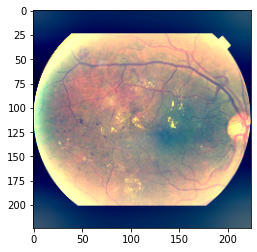

In [ ]:
plt.imshow(x_train[0])

In [ ]:
y_train = pd.get_dummies(train_df['diagnosis']).values

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, 
    test_size=0.15, 
    random_state=2020
)

In [ ]:
BATCH_SIZE = 64

train_datagen = ImageDataGenerator(rescale=1./ 255.,
                                   rotation_range=25,                               
                                   #shear_range=0.01,
                                   zoom_range=[0.9, 1.25],
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   #data_format='channels_last',
                                   samplewise_center=True,
                                   samplewise_std_normalization= True)
                                   #featurewise_center=True, 
                                   #featurewise_std_normalization=True)



#Usar el generador original
data_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2020)

test_datagen = ImageDataGenerator(rescale=1./ 255.,
                                   #zoom_range=[0.9, 1.25],
                                   #horizontal_flip=True,
                                   #vertical_flip=True,
                                   samplewise_center=True,
                                   samplewise_std_normalization= True)
                                   #featurewise_center=True, 
                                   #featurewise_std_normalization=True)

vdata_gen =  test_datagen.flow(x_val, y_val, batch_size=BATCH_SIZE, seed=2020)

In [ ]:
train_datagen.fit(x_train)

In [ ]:
test_datagen.fit(x_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


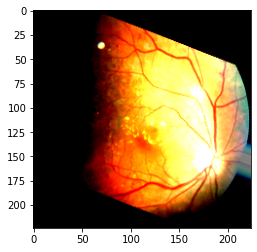

In [ ]:
plt.imshow(data_generator[0][0][8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


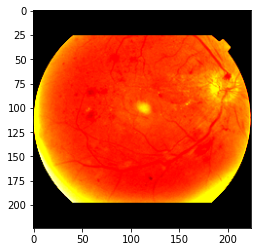

In [ ]:
plt.imshow(vdata_gen[0][0][6])

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation

In [ ]:
model1 = tf.keras.Sequential()

model1.add(Conv2D(32, (3, 3), padding='same', input_shape=(224,224,3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(128, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(256, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(1024, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(1024))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))

model1.add(Flatten())
model1.add(Dense(512))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))

model1.add(Dense(5, activation='softmax'))
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
activation_28 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
activation_29 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 56, 56, 128)      

In [ ]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

In [ ]:
model1.compile(loss='binary_crossentropy',optimizer= 'adam',metrics=['accuracy'])

In [ ]:
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]

In [ ]:
model1.fit(data_generator, epochs=20, validation_data=vdata_gen,callbacks=[callback_list])

Epoch 1/20
49/49 [==============================] - 30s 622ms/step - loss: 0.1528 - accuracy: 0.8316 - val_loss: 0.2058 - val_accuracy: 0.7855
Epoch 2/20
49/49 [==============================] - 30s 612ms/step - loss: 0.1517 - accuracy: 0.8374 - val_loss: 0.2001 - val_accuracy: 0.8000
Epoch 3/20
49/49 [==============================] - 31s 624ms/step - loss: 0.1542 - accuracy: 0.8326 - val_loss: 0.2024 - val_accuracy: 0.8036
Epoch 4/20
49/49 [==============================] - 30s 609ms/step - loss: 0.1475 - accuracy: 0.8397 - val_loss: 0.1994 - val_accuracy: 0.7964
Epoch 5/20
49/49 [==============================] - 30s 612ms/step - loss: 0.1501 - accuracy: 0.8374 - val_loss: 0.2195 - val_accuracy: 0.7982
Epoch 6/20
49/49 [==============================] - 30s 610ms/step - loss: 0.1488 - accuracy: 0.8358 - val_loss: 0.2070 - val_accuracy: 0.8036
Epoch 7/20
49/49 [==============================] - ETA: 0s - loss: 0.1422 - accuracy: 0.8499
Epoch 00007: ReduceLROnPlateau reducing learning

In [ ]:
val_preds = model1.predict(x_val,verbose = 1)

18/18 [==============================] - 0s 11ms/step


In [ ]:
vdata_gencomplete =  test_datagen.flow(x_val, y_val, batch_size=1, seed=2020)

In [ ]:
val_preds = model1.predict(vdata_gencomplete,verbose = 1)

550/550 [==============================] - 1s 2ms/step


In [ ]:
val_preds

array([[6.45475015e-02, 7.83981204e-01, 1.35282144e-01, 2.43178778e-03,
        1.37573937e-02],
       [9.88191903e-01, 1.07320305e-02, 1.06872607e-03, 6.81148293e-08,
        7.20521666e-06],
       [9.84689454e-04, 2.37350594e-02, 3.51057082e-01, 3.57910693e-01,
        2.66312569e-01],
       ...,
       [6.71359850e-03, 9.00740325e-02, 6.75542891e-01, 1.10403001e-01,
        1.17266476e-01],
       [2.67453230e-04, 3.89622129e-03, 6.24886155e-02, 1.07060231e-01,
        8.26287448e-01],
       [7.36250076e-05, 8.89007468e-03, 6.74950778e-01, 6.66412190e-02,
        2.49444336e-01]], dtype=float32)

In [ ]:
val_preds1 = [np.argmax(pred) for pred in val_preds]

In [ ]:
val_preds1

[1,
 0,
 3,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 3,
 0,
 0,
 4,
 4,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 1,
 2,
 0,
 1,
 0,
 2,
 0,
 1,
 4,
 0,
 2,
 2,
 0,
 0,
 3,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 3,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 1,
 0,
 4,
 0,
 3,
 0,
 3,
 0,
 2,
 3,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 4,
 2,
 0,
 2,
 0,
 2,
 3,
 0,
 4,
 2,
 0,
 0,
 1,
 2,
 0,
 0,
 4,
 3,
 0,
 0,
 3,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 4,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 1,
 0,
 2,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 1,
 1,
 0,
 0,
 2,
 0,
 2,
 0,
 1,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 4,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 3,
 0,


In [ ]:
y_val1 = np.array([[0,0,0,0,0]])
vdata_gencomplete[549][1]

for i in range(550):
  y_val1 =np.append(y_val1, vdata_gencomplete[i][1], axis=0)

In [ ]:
y_val1 = np.delete(y_val1,0, axis=0)


In [ ]:
y_val1

array([[0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0]])

In [ ]:
y_val11 = [np.argmax(pred1) for pred1 in y_val1]

In [ ]:
y_val11 = [np.argmax(pred1) for pred1 in y_val1]

[1,
 0,
 4,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 2,
 3,
 0,
 2,
 0,
 0,
 4,
 4,
 0,
 0,
 2,
 3,
 1,
 2,
 1,
 4,
 2,
 4,
 2,
 0,
 0,
 0,
 4,
 0,
 0,
 2,
 0,
 0,
 0,
 3,
 2,
 0,
 1,
 2,
 0,
 1,
 0,
 2,
 0,
 3,
 0,
 0,
 3,
 2,
 0,
 0,
 4,
 2,
 2,
 0,
 0,
 0,
 0,
 3,
 0,
 1,
 2,
 3,
 0,
 2,
 0,
 0,
 1,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 1,
 2,
 0,
 0,
 0,
 4,
 0,
 0,
 2,
 0,
 2,
 0,
 4,
 0,
 2,
 0,
 3,
 0,
 2,
 4,
 0,
 0,
 0,
 3,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 1,
 4,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 3,
 0,
 4,
 2,
 0,
 0,
 1,
 2,
 0,
 0,
 4,
 2,
 0,
 0,
 4,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 4,
 0,
 1,
 0,
 2,
 2,
 0,
 4,
 0,
 0,
 0,
 2,
 0,
 0,
 1,
 4,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 0,
 1,
 3,
 0,
 0,
 1,
 1,
 0,
 0,
 3,
 0,
 2,
 0,
 1,
 0,
 2,
 0,
 4,
 0,
 2,
 0,
 0,
 2,
 4,
 0,
 3,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 2,
 0,
 2,
 1,
 0,
 1,
 2,
 0,


In [ ]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(val_preds1, y_val11, weights='quadratic'))

Train Cohen Kappa score: 0.878


In [ ]:
densenet = tf.keras.applications.DenseNet121(
    weights='/content/gdrive/My Drive/APTOS1/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

In [ ]:
model = tf.keras.Sequential()
model.add(densenet)
model.add(tf.keras.layers.GlobalAveragePooling2D())


model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(5, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 5)                

In [ ]:
tf.keras.optimizers.SGD()

In [ ]:
model.compile(loss='binary_crossentropy',optimizer= tf.keras.optimizers.SGD(0.001),metrics=['accuracy'])

In [ ]:
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]

In [ ]:
model.fit(data_generator, epochs=20, validation_data=vdata_gen,callbacks=[callback_list])

Epoch 1/20
49/49 [==============================] - 33s 682ms/step - loss: 0.1227 - accuracy: 0.8744 - val_loss: 0.1453 - val_accuracy: 0.8255
Epoch 2/20
49/49 [==============================] - 32s 647ms/step - loss: 0.1196 - accuracy: 0.8772 - val_loss: 0.1453 - val_accuracy: 0.8255
Epoch 3/20
49/49 [==============================] - 32s 650ms/step - loss: 0.1220 - accuracy: 0.8795 - val_loss: 0.1451 - val_accuracy: 0.8273
Epoch 4/20
49/49 [==============================] - 31s 637ms/step - loss: 0.1225 - accuracy: 0.8721 - val_loss: 0.1452 - val_accuracy: 0.8255
Epoch 5/20
49/49 [==============================] - 32s 643ms/step - loss: 0.1171 - accuracy: 0.8808 - val_loss: 0.1451 - val_accuracy: 0.8273
Epoch 6/20
49/49 [==============================] - ETA: 0s - loss: 0.1224 - accuracy: 0.8731
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
49/49 [==============================] - 31s 641ms/step - loss: 0.1224 - accuracy: 0.8731 - val_loss: 0.1453 - 

In [ ]:
val_preds = model.predict(vdata_gencomplete,verbose = 1)

550/550 [==============================] - 7s 12ms/step


In [ ]:
val_preds1 = [np.argmax(pred) for pred in val_preds]

In [ ]:
y_val1 = np.array([[0,0,0,0,0]])
vdata_gencomplete[549][1]

for i in range(550):
  y_val1 =np.append(y_val1, vdata_gencomplete[i][1], axis=0)

y_val1 = np.delete(y_val1,0, axis=0)

y_val11 = [np.argmax(pred1) for pred1 in y_val1]


In [ ]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(val_preds1, y_val11, weights='quadratic'))

Train Cohen Kappa score: 0.902


prueba tres

In [ ]:
y_train = pd.get_dummies(train_df['diagnosis']).values

In [ ]:
x_train.shape

(3662, 512, 512, 3)

In [ ]:
y_train.shape

(3662, 5)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, 
    test_size=0.15, 
    random_state=2020
)

In [ ]:
x_train.shape

(3112, 512, 512, 3)

In [ ]:
BATCH_SIZE = 8

train_datagen = ImageDataGenerator(rescale=1./ 255.,
                                   rotation_range=25,                               
                                   #shear_range=0.01,
                                   zoom_range=[0.9, 1.25],
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   #data_format='channels_last',
                                   samplewise_center=True,
                                   samplewise_std_normalization= True)
                                   #featurewise_center=True, 
                                   #featurewise_std_normalization=True)



#Usar el generador original
data_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2020)

test_datagen = ImageDataGenerator(rescale=1./ 255.,
                                   #zoom_range=[0.9, 1.25],
                                   #horizontal_flip=True,
                                   #vertical_flip=True,
                                   samplewise_center=True,
                                   samplewise_std_normalization= True)
                                   #featurewise_center=True, 
                                   #featurewise_std_normalization=True)

vdata_gen =  test_datagen.flow(x_val, y_val, batch_size=BATCH_SIZE, seed=2020)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


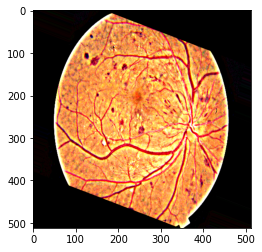

In [ ]:
plt.imshow(data_generator[0][0][7])

In [ ]:
data_generator[0][1][7]

array([0, 0, 1, 0, 0], dtype=uint8)

In [ ]:
densenet = tf.keras.applications.DenseNet121(
    weights='/content/gdrive/My Drive/APTOS1/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(512,512,3)
)

In [ ]:
model = tf.keras.Sequential()
model.add(densenet)
model.add(tf.keras.layers.GlobalAveragePooling2D())


model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(5, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 16, 16, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1

In [ ]:
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]

In [ ]:
model.compile(loss='binary_crossentropy',optimizer= 'sgd',metrics=['accuracy'])

In [ ]:
model.fit(data_generator, epochs=20, validation_data=vdata_gen,callbacks=[callback_list])

Epoch 1/20
389/389 [==============================] - 165s 424ms/step - loss: 0.1801 - accuracy: 0.7812 - val_loss: 0.1620 - val_accuracy: 0.7945
Epoch 2/20
389/389 [==============================] - 164s 421ms/step - loss: 0.1807 - accuracy: 0.7879 - val_loss: 0.1622 - val_accuracy: 0.7982
Epoch 3/20
389/389 [==============================] - 164s 422ms/step - loss: 0.1781 - accuracy: 0.7988 - val_loss: 0.1619 - val_accuracy: 0.7945
Epoch 4/20
389/389 [==============================] - 165s 425ms/step - loss: 0.1780 - accuracy: 0.7956 - val_loss: 0.1618 - val_accuracy: 0.7927
Epoch 5/20
389/389 [==============================] - 165s 425ms/step - loss: 0.1787 - accuracy: 0.7908 - val_loss: 0.1622 - val_accuracy: 0.7982
Epoch 6/20
389/389 [==============================] - ETA: 0s - loss: 0.1790 - accuracy: 0.7902
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
389/389 [==============================] - 165s 424ms/step - loss: 0.1790 - accuracy: 0.7902 -

In [ ]:
vdata_gencomplete =  test_datagen.flow(x_val, y_val, batch_size=1, seed=2020)

In [ ]:
val_preds = model.predict(vdata_gencomplete,verbose = 1)
val_preds1 = [np.argmax(pred) for pred in val_preds]

550/550 [==============================] - 10s 18ms/step


In [ ]:
y_val1 = np.array([[0,0,0,0,0]])
vdata_gencomplete[549][1]

for i in range(550):
  y_val1 =np.append(y_val1, vdata_gencomplete[i][1], axis=0)

y_val1 = np.delete(y_val1,0, axis=0)

y_val11 = [np.argmax(pred1) for pred1 in y_val1]

In [ ]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(val_preds1, y_val11, weights='quadratic'))

Train Cohen Kappa score: 0.838


In [ ]:
from numpy import load

x_train = load('/content/gdrive/My Drive/xtrain2512.npy')

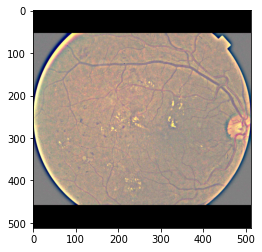

In [ ]:
x_train.shape
plt.imshow(x_train[0])

In [ ]:
y = pd.get_dummies(train_df['diagnosis']).values

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y, 
    test_size=0.15, 
    random_state=2020
)

In [ ]:
BATCH_SIZE = 8

train_datagen = ImageDataGenerator(rescale=1./ 255.,
                                   rotation_range=45,                               
                                   shear_range=0.01,
                                   zoom_range=[0.9, 1.25],
                                   horizontal_flip=True,
                                   vertical_flip=True)
                                   #data_format='channels_last',
                                   #samplewise_center=True,
                                   #samplewise_std_normalization= True)
                                   #featurewise_center=True, 
                                   #featurewise_std_normalization=True)



#Usar el generador original
data_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2020)

test_datagen = ImageDataGenerator(rescale=1./ 255.,
                                   horizontal_flip=True,
                                   vertical_flip=True)

                                   #samplewise_center=True,
                                   #amplewise_std_normalization= True)
                                   #featurewise_center=True, 
                                   #featurewise_std_normalization=True)

vdata_gen =  test_datagen.flow(x_val, y_val, batch_size=BATCH_SIZE, seed=2020)

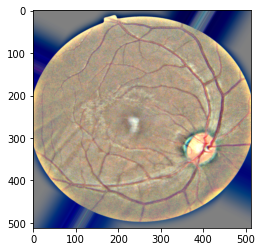

In [ ]:
plt.imshow(data_generator[0][0][4])

In [ ]:
densenet = tf.keras.applications.DenseNet121(
    weights='/content/gdrive/My Drive/APTOS1/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(512,512,3)
)

In [ ]:
model = tf.keras.Sequential()
model.add(densenet)
model.add(tf.keras.layers.GlobalAveragePooling2D())


model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(5, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 16, 16, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1

In [ ]:
model.compile(loss='binary_crossentropy',optimizer= 'sgd',metrics=['accuracy'])

In [ ]:
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]

In [ ]:
model.fit(data_generator, epochs=20, validation_data=vdata_gen,callbacks=[callback_list])

Epoch 1/20
389/389 [==============================] - 160s 410ms/step - loss: 0.3193 - accuracy: 0.8859 - val_loss: 0.4952 - val_accuracy: 0.8255
Epoch 2/20
389/389 [==============================] - 159s 410ms/step - loss: 0.3130 - accuracy: 0.8879 - val_loss: 0.4822 - val_accuracy: 0.8073
Epoch 3/20
389/389 [==============================] - 160s 411ms/step - loss: 0.2954 - accuracy: 0.8914 - val_loss: 0.5124 - val_accuracy: 0.8345
Epoch 4/20
389/389 [==============================] - 159s 408ms/step - loss: 0.3018 - accuracy: 0.8936 - val_loss: 0.5647 - val_accuracy: 0.8291
Epoch 5/20
389/389 [==============================] - ETA: 0s - loss: 0.2913 - accuracy: 0.8965
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
389/389 [==============================] - 159s 408ms/step - loss: 0.2913 - accuracy: 0.8965 - val_loss: 0.6015 - val_accuracy: 0.8400
Epoch 6/20
389/389 [==============================] - 159s 407ms/step - loss: 0.2552 - accuracy: 0.9094 - 

In [ ]:
vdata_gencomplete =  test_datagen.flow(x_val, y_val, batch_size=1, seed=2020)

In [ ]:
val_preds = model.predict(vdata_gencomplete,verbose = 1)
val_preds1 = [np.argmax(pred) for pred in val_preds]

550/550 [==============================] - 10s 17ms/step


In [ ]:
y_val1 = np.array([[0,0,0,0,0]])
vdata_gencomplete[549][1]

for i in range(550):
  y_val1 =np.append(y_val1, vdata_gencomplete[i][1], axis=0)

y_val1 = np.delete(y_val1,0, axis=0)

y_val11 = [np.argmax(pred1) for pred1 in y_val1]

In [ ]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(val_preds1, y_val11, weights='quadratic'))

Train Cohen Kappa score: 0.887


intento 4

In [ ]:
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = train_df['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [ ]:
train_datagen =ImageDataGenerator(rescale=1./255, 
                           rotation_range=360,
                           horizontal_flip=True,
                           vertical_flip=True)

data_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2020)

test_datagen = ImageDataGenerator(rescale=1./ 255.,
                                   horizontal_flip=True,
                                   vertical_flip=True)

                                   #samplewise_center=True,
                                   #amplewise_std_normalization= True)
                                   #featurewise_center=True, 
                                   #featurewise_std_normalization=True)

vdata_gen =  test_datagen.flow(x_val, y_val, batch_size=BATCH_SIZE, seed=2020)

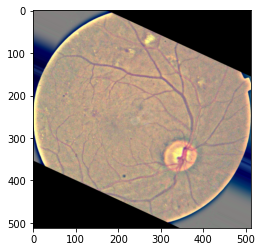

In [ ]:
plt.imshow(data_generator[0][0][3])

In [ ]:
densenet = tf.keras.applications.DenseNet121(
    weights='/content/gdrive/My Drive/APTOS1/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(512,512,3)
)

model = tf.keras.Sequential()
model.add(densenet)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(2058, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(5, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 16, 16, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2058)              2109450   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2058)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10295     
Total params: 9,157,249
Trainable params: 9,073,601
Non-trainable params: 83,648
_________________________________________

In [ ]:
for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 16, 16, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2058)              2109450   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2058)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10295     
Total params: 9,157,249
Trainable params: 2,119,745
Non-trainable params: 7,037,504
______________________________________

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr=WARMUP_LEARNING_RATE),loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
history_warmup = model.fit(data_generator,epochs=WARMUP_EPOCHS,validation_data=vdata_gen,verbose=1)

Epoch 1/2
389/389 [==============================] - 164s 422ms/step - loss: 1.1688 - accuracy: 0.6218 - val_loss: 0.7729 - val_accuracy: 0.7182
Epoch 2/2
389/389 [==============================] - 161s 414ms/step - loss: 0.8850 - accuracy: 0.6703 - val_loss: 0.7248 - val_accuracy: 0.7491


In [ ]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 16, 16, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2058)              2109450   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2058)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10295     
Total params: 9,157,249
Trainable params: 9,073,601
Non-trainable params: 83,648
_________________________________________

In [ ]:
history_warmup = model.fit(data_generator,epochs=EPOCHS,validation_data=vdata_gen,callbacks=[callback_list],verbose=1)

Epoch 1/40
389/389 [==============================] - 168s 433ms/step - loss: 0.2635 - accuracy: 0.7089 - val_loss: 0.2122 - val_accuracy: 0.7909
Epoch 2/40
389/389 [==============================] - 166s 427ms/step - loss: 0.2199 - accuracy: 0.7645 - val_loss: 0.1911 - val_accuracy: 0.8127
Epoch 3/40
389/389 [==============================] - 165s 424ms/step - loss: 0.1954 - accuracy: 0.7902 - val_loss: 0.1826 - val_accuracy: 0.8109
Epoch 4/40
389/389 [==============================] - 164s 422ms/step - loss: 0.1895 - accuracy: 0.7940 - val_loss: 0.1901 - val_accuracy: 0.8036
Epoch 5/40
389/389 [==============================] - 165s 423ms/step - loss: 0.1748 - accuracy: 0.8107 - val_loss: 0.1722 - val_accuracy: 0.8200
Epoch 6/40
389/389 [==============================] - 165s 423ms/step - loss: 0.1712 - accuracy: 0.8133 - val_loss: 0.2398 - val_accuracy: 0.8109
Epoch 7/40
389/389 [==============================] - 164s 422ms/step - loss: 0.1699 - accuracy: 0.8165 - val_loss: 0.1658 -

In [ ]:
vdata_gencomplete =  test_datagen.flow(x_val, y_val, batch_size=1, seed=2020)

In [ ]:
val_preds = model.predict(vdata_gencomplete,verbose = 1)
val_preds1 = [np.argmax(pred) for pred in val_preds]

550/550 [==============================] - 10s 18ms/step


In [ ]:
y_val1 = np.array([[0,0,0,0,0]])
vdata_gencomplete[549][1]

for i in range(550):
  y_val1 =np.append(y_val1, vdata_gencomplete[i][1], axis=0)

y_val1 = np.delete(y_val1,0, axis=0)

y_val11 = [np.argmax(pred1) for pred1 in y_val1]

In [ ]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(val_preds1, y_val11, weights='quadratic'))

Train Cohen Kappa score: 0.905


In [ ]:
from keras import applications

resnet=applications.ResNet50(weights='imagenet', include_top=False,input_shape=(512,512,3))


model = tf.keras.Sequential()
model.add(resnet)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(2058, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(5, activation='softmax'))
model.summary()

94773248/94765736 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 16, 16, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2058)              4216842   
_________________________________________________________________
dropout_3 (Dropout)          (None, 2058)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 10295     
Total params: 27,814,849
Trainable params: 27,761,729
N

In [ ]:
for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 16, 16, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2058)              4216842   
_________________________________________________________________
dropout_3 (Dropout)          (None, 2058)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 10295     
Total params: 27,814,849
Trainable params: 4,227,137
Non-trainable params: 23,587,712
__________________________________

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr=WARMUP_LEARNING_RATE),loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
history_warmup = model.fit(data_generator,epochs=WARMUP_EPOCHS,validation_data=vdata_gen,verbose=1)

Epoch 1/2
389/389 [==============================] - 165s 425ms/step - loss: 2.3575 - accuracy: 0.3901 - val_loss: 1.2656 - val_accuracy: 0.5509
Epoch 2/2
389/389 [==============================] - 163s 419ms/step - loss: 1.3738 - accuracy: 0.4569 - val_loss: 1.2259 - val_accuracy: 0.5400


In [ ]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 16, 16, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2058)              4216842   
_________________________________________________________________
dropout_3 (Dropout)          (None, 2058)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 10295     
Total params: 27,814,849
Trainable params: 27,761,729
Non-trainable params: 53,120
_____________________________________

In [ ]:
history_warmup = model.fit(data_generator,epochs=EPOCHS,validation_data=vdata_gen,callbacks=[callback_list],verbose=1)

Epoch 1/40
389/389 [==============================] - ETA: 0s - loss: 0.2524 - accuracy: 0.7262